# Intake vs Historical Completion – Distribution Mismatch (CAISO)

This notebook compares **what enters the queue** (Cluster 14 + Cluster 15 intake snapshots) against **what historically completes** using the Public Queue Report.

Goal: identify **composition mismatches** that may indicate structural interconnection risk (descriptive, not predictive).

Inputs (from earlier notebooks):
- `data/processed/cluster14_intake_clean.csv` (Notebook 05)
- `data/processed/cluster15_clean.csv` (Notebook 03)
- `data/processed/public_queue_clean.csv` (Notebook 02)

Outputs:
- Summary tables → `outputs/tables/`
- Figures → `outputs/figures/`


## 1) Imports

In [12]:
import sys
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

print('Python:', sys.version)
print('Executable:', sys.executable)


Python: 3.11.9 (tags/v3.11.9:de54cf5, Apr  2 2024, 10:12:12) [MSC v.1938 64 bit (AMD64)]
Executable: C:\Users\danci\Interconnection-Queue-Intelligence\.venv\Scripts\python.exe


## 2) Paths + outputs folders

Robust to running from `notebooks/`.

In [13]:
ROOT = Path.cwd()
if ROOT.name == "notebooks":
    ROOT = ROOT.parent

PROCESSED = ROOT / "data" / "processed"
OUTPUTS = ROOT / "outputs"
FIGURES = OUTPUTS / "figures"
TABLES = OUTPUTS / "tables"

FIGURES.mkdir(parents=True, exist_ok=True)
TABLES.mkdir(parents=True, exist_ok=True)

print("ROOT:", ROOT)
print("Processed files:", [p.name for p in PROCESSED.glob("*")])


ROOT: C:\Users\danci\Interconnection-Queue-Intelligence
Processed files: ['cluster14_intake_clean.csv', 'cluster15_clean.csv', 'public_queue_clean.csv', '_cluster15_raw.csv', '_cluster15_withdrawn_raw.csv', '_public_queue_raw_parsed.csv']


## 3) Load datasets

We load the cleaned datasets produced earlier. If Cluster 14 processed output is missing, run Notebook 05 first.

In [14]:
public_path = PROCESSED / "public_queue_clean.csv"
cluster15_path = PROCESSED / "cluster15_clean.csv"
cluster14_path = PROCESSED / "cluster14_intake_clean.csv"

public = pd.read_csv(public_path)
cluster15 = pd.read_csv(cluster15_path)

if not cluster14_path.exists():
    raise FileNotFoundError(
        f"Missing {cluster14_path}. Run Notebook 05 first to create it."
    )
cluster14 = pd.read_csv(cluster14_path)

public.shape, cluster14.shape, cluster15.shape


((2285, 17), (363, 17), (170, 27))

## 4) Define the historical 'completed' set

The Public Queue Report provides system-wide snapshot outcomes. We use the `completed` subset as a proxy for historical projects that made it through the process (across many cohorts).

In [15]:
# Expect a 'status' column with values like active/withdrawn/completed
print(public["status"].value_counts(dropna=False))

completed = public[public["status"].str.lower().eq("completed")].copy()
active_all = public[public["status"].str.lower().eq("active")].copy()
withdrawn_all = public[public["status"].str.lower().eq("withdrawn")].copy()

completed.shape, active_all.shape, withdrawn_all.shape


status
withdrawn    1717
active        332
completed     236
Name: count, dtype: int64


((236, 17), (332, 17), (1717, 17))

## 5) Normalize key fields for comparison

We focus on two comparable dimensions available in all datasets:
- **Project size** (MW)
- **Technology category**

Cluster 14 intake uses `total_mw_at_poi`.
Cluster 15 uses `net_mw`.
Public queue uses `net_mw` (cleaned in Notebook 02).

In [16]:
# --- MW series (drop non-positive or missing) ---
c14_mw = pd.to_numeric(cluster14.get("total_mw_at_poi"), errors="coerce")
c15_mw = pd.to_numeric(cluster15.get("net_mw"), errors="coerce")
comp_mw = pd.to_numeric(completed.get("net_mw"), errors="coerce")

c14_mw = c14_mw[(c14_mw > 0) & (c14_mw.notna())]
c15_mw = c15_mw[(c15_mw > 0) & (c15_mw.notna())]
comp_mw = comp_mw[(comp_mw > 0) & (comp_mw.notna())]

len(c14_mw), len(c15_mw), len(comp_mw)


(360, 170, 233)

## 6) Figure: MW distributions (intake vs completed)

We compare MW distributions using log-scaled x-axis so small and large projects are visible simultaneously.

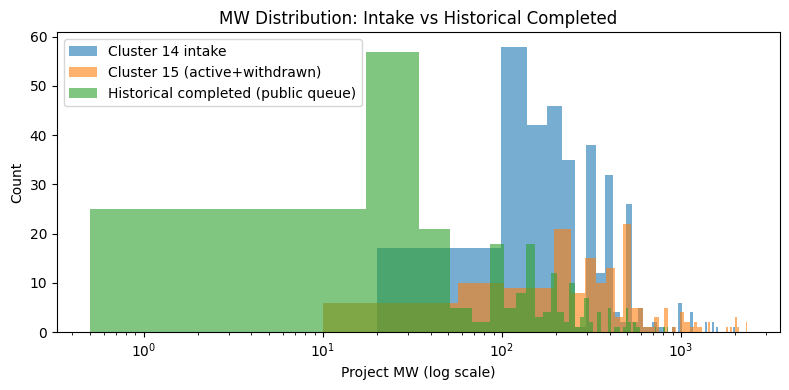

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures\mw_distribution_intake_vs_completed.png


In [17]:
plt.figure(figsize=(8,4))
plt.hist(c14_mw, bins=50, alpha=0.6, label="Cluster 14 intake")
plt.hist(c15_mw, bins=50, alpha=0.6, label="Cluster 15 (active+withdrawn)")
plt.hist(comp_mw, bins=50, alpha=0.6, label="Historical completed (public queue)")

plt.xscale("log")
plt.title("MW Distribution: Intake vs Historical Completed")
plt.xlabel("Project MW (log scale)")
plt.ylabel("Count")
plt.legend()
plt.tight_layout()

out = FIGURES / "mw_distribution_intake_vs_completed.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)


## 7) Table: MW summary statistics

This helps quantify whether historical completed projects skew larger than intake projects.

In [18]:
mw_summary = pd.DataFrame({
    "cluster14_intake": c14_mw.describe(percentiles=[0.1,0.25,0.5,0.75,0.9]),
    "cluster15_cohort": c15_mw.describe(percentiles=[0.1,0.25,0.5,0.75,0.9]),
    "historical_completed": comp_mw.describe(percentiles=[0.1,0.25,0.5,0.75,0.9]),
}).T

mw_summary.to_csv(TABLES / "mw_summary_intake_vs_completed.csv")
mw_summary


,count,mean,std,min,10%,25%,50%,75%,90%,max
cluster14_intake,360.0,294.431349,263.254245,20.000,100.000,130.0000,215.000,400.000000,500.000000,2000.00
cluster15_cohort,170.0,495.695573,464.711599,10.072,103.734,204.9075,365.542,558.482333,1069.333626,2346.96
historical_completed,233.0,141.342864,157.989554,0.500,15.000,20.0000,100.000,200.000000,350.000000,850.00


## 8) Technology mix: intake vs completed

We compare technology shares across:
- Cluster 14 intake
- Cluster 15 cohort (active + withdrawn)
- Public queue completed

This requires a compatible technology label in each dataset.
Notebook 05 generates `tech_category` for Cluster 14.
Notebook 03 generates `technology` for Cluster 15.
Notebook 02 generates `technology` (or similar) for the public queue.

If the public queue file uses a different column name, we try common fallbacks.

In [19]:
def pick_col(df, options):
    for c in options:
        if c in df.columns:
            return c
    return None

c14_tech_col = pick_col(cluster14, ["tech_category", "technology", "technology_category"])
c15_tech_col = pick_col(cluster15, ["technology", "technology_category", "tech_category"])
pub_tech_col = pick_col(public, ["technology", "technology_category", "tech_category", "fuel_category"])

print("Cluster14 tech col:", c14_tech_col)
print("Cluster15 tech col:", c15_tech_col)
print("Public queue tech col:", pub_tech_col)

if c14_tech_col is None or c15_tech_col is None or pub_tech_col is None:
    raise KeyError(
        "Missing a technology column in one of the datasets. "
        "Check processed CSV headers and adjust the column options."
    )

c14_tech = cluster14[c14_tech_col].astype(str).str.strip().str.lower()
c15_tech = cluster15[c15_tech_col].astype(str).str.strip().str.lower()
comp_tech = completed[pub_tech_col].astype(str).str.strip().str.lower()

# Basic cleanup
for s in (c14_tech, c15_tech, comp_tech):
    pass


Cluster14 tech col: technology
Cluster15 tech col: technology
Public queue tech col: technology


### Technology share table

In [20]:
tech_share = pd.DataFrame({
    "cluster14_intake": c14_tech.value_counts(normalize=True),
    "cluster15_cohort": c15_tech.value_counts(normalize=True),
    "historical_completed": comp_tech.value_counts(normalize=True),
}).fillna(0).sort_values("historical_completed", ascending=False)

tech_share.to_csv(TABLES / "technology_share_intake_vs_completed.csv")
tech_share.head(20)


,cluster14_intake,cluster15_cohort,historical_completed
technology,,,
solar,0.038567,0.0,0.398305
other,0.005510,1.0,0.233051
hybrid_solar_storage,0.000000,0.0,0.161017
storage,0.000000,0.0,0.122881
wind,0.024793,0.0,0.084746
battery,0.595041,0.0,0.000000
hybrid (solar+storage),0.316804,0.0,0.000000
geothermal,0.002755,0.0,0.000000
hybrid (other),0.016529,0.0,0.000000


### Figure: Technology share comparison (top categories)

We plot the top technology categories by completed-share.

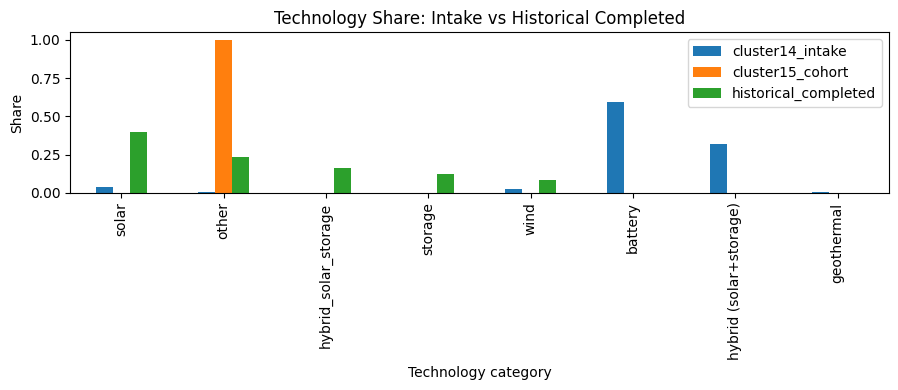

Saved: C:\Users\danci\Interconnection-Queue-Intelligence\outputs\figures\technology_share_intake_vs_completed.png


In [21]:
top_n = 8
top_idx = tech_share.sort_values("historical_completed", ascending=False).head(top_n).index

plot_df = tech_share.loc[top_idx].copy()
ax = plot_df.plot(kind="bar", figsize=(9,4))
ax.set_title("Technology Share: Intake vs Historical Completed")
ax.set_ylabel("Share")
ax.set_xlabel("Technology category")
plt.tight_layout()

out = FIGURES / "technology_share_intake_vs_completed.png"
plt.savefig(out, dpi=200)
plt.show()
print("Saved:", out)


## 9) A simple 'mismatch score' (descriptive)

We compute an absolute-difference score between each intake cohort’s tech mix and the completed mix.

Interpretation:
- Higher score → intake composition is less aligned with what historically completes (descriptive signal only).

In [22]:
def l1_distance(p, q):
    # p, q are series indexed by category with shares
    idx = p.index.union(q.index)
    p2 = p.reindex(idx, fill_value=0)
    q2 = q.reindex(idx, fill_value=0)
    return (p2 - q2).abs().sum()

c14_score = l1_distance(tech_share["cluster14_intake"], tech_share["historical_completed"])
c15_score = l1_distance(tech_share["cluster15_cohort"], tech_share["historical_completed"])

mismatch = pd.DataFrame({
    "l1_distance_to_completed": {
        "cluster14_intake": c14_score,
        "cluster15_cohort": c15_score
    }
})

mismatch.to_csv(TABLES / "technology_mismatch_scores.csv")
mismatch


,l1_distance_to_completed
cluster14_intake,1.862259
cluster15_cohort,1.533898


## 10) Key takeaways (draft)

Use these as a starting point for your narrative; adjust once you see the numbers:

- **Completed projects may skew larger** than intake projects, suggesting size/feasibility selection.
- Technology composition at intake can differ from the completed portfolio, indicating potential structural mismatch.
- These results are **descriptive** and do not imply causality or predict any individual project’s outcome.

## Limitations

- Cluster 14 dataset is an intake snapshot with no official per-project outcomes.
- Completed projects are pooled across cohorts and years.
- Technology labels are simplified and may collapse nuanced categories.

## Outputs

Saved to:
- `outputs/figures/`
- `outputs/tables/`
